In [51]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import time

# Paths and stuff
import os
import sys

sys.path.append('/home/shreyas/pySICOPOLIS/src')
from pySICOPOLIS import *

In [52]:
ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init = xr.open_dataset('/home/shreyas/update_to_develop_sicopolis/sicopolis_spinups/sico_out/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka/grl40_bm5_paleo17a_CT4_BH0_8point5CS_spinup_0ka0006.nc')

# Manually verify gradients in sicopolis_validation_genctrl_nolog match sicopolis_validation. A quick check of SUM(varb) for each var should suffice.
# Once you are confident in sicopolis_validation_genctrl_nolog, use it to verify sicopolis_validation_genctrl_prof.
sicopolis_validation_genctrl_nolog_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_validation_genctrl_nolog'
sicopolis_validation_genctrl_prof_dir = '/home/shreyas/update_to_develop_sicopolis/sicopolis_validation_genctrl_prof'

H_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/bm5_data_40kms.nc")
age_data_40 = xr.open_dataset("/scratch2/shreyas/GrIS_paleo_data/age_data_40kms.nc")

H_data = H_data_40["H"].data
H_uncert_data = H_data_40["H_uncert"].data
zl_uncert_data = H_data_40["zl_uncert"].data

age_c_data = age_data_40["age_c"].data
age_c_uncert_data = age_data_40["age_c_uncert"].data

mask_age_c = np.zeros(age_c_data.shape)
for kc in range(age_c_data.shape[0]):
    for j in range(age_c_data.shape[1]):
        for i in range(age_c_data.shape[2]):
            if age_c_uncert_data[kc, j, i] > 0 and age_c_data[kc, j, i] >= 0 and age_c_data[kc, j, i] <= 134000 and H_data[j, i] >= 2000.0:
                mask_age_c[kc, j, i] = 1.0

In [53]:
# Since all we need is fake sampling to get all the nercdf files including prior files, no need to change simulation name I think. 
# The generated input files should work for both cases as long as the same variables are activated in the same order.
# NTDAMAX will have to be set to 11 in the SVC case to make it work though.
simulation = 'grl40_bm5_paleo17a_CT4_BH0_AC_BM5_ZLC_m11ka_pkp'
# simulation = 'grl40_bm5_paleo17a_nudged_CT4_BH0_m21ka_pkp'

dict_sico_out_folder_prefixes = {"nodiff": "N",
                                 "tlm": "FORWARD",
                                 "adj": "ADJOINT",
                                 "tlm_action": "FORWARDHESSACTION",
                                 "adj_action": "ADJHESSACTION"}
dict_ad_exec_cmds_suffixes = {"nodiff": "nodiff",
                              "tlm": "forward",
                              "adj": "adjoint",
                              "tlm_action": "forwardhessaction",
                              "adj_action": "adjointhessaction"}
dict_ad_log_file_suffixes = {"nodiff": "nodiff",
                             "tlm": "tlm",
                             "adj": "adj",
                             "tlm_action": "tlm_hessaction",
                             "adj_action": "adj_hessaction"}
dict_ad_nc_suffixes = {"nodiff": "nodiff",
                       "tlm": "tlm",
                       "adj": "adj",
                       "tlm_action": "tlm_hessaction",
                       "adj_action": "adj_hessaction"}

KCMAX = 80
exp_sigma_level = dataCleaner.exp_sigma_level(zeta = np.arange(0,1+1./KCMAX,1./KCMAX),
                                              exponent = 2.0)
KRMAX = 40
zeta_r = np.arange(0.,1. + 1.0/KRMAX, 1.0/KRMAX)
xModel40       = np.arange(-72.,97.,4.0)*10
yModel40       = np.arange(-345.,-56.,4.0)*10
time_ad = np.arange(12, dtype=float)
IMAX = xModel40.shape[0]-1
JMAX = yModel40.shape[0]-1
NTDAMAX = time_ad.shape[0]-1

delta_tda_const = np.zeros((JMAX+1, IMAX+1), dtype=float)
data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['q_geo'].data
log_q_geo = np.where(data > 0, np.log10(data), -10)
zs = np.zeros((JMAX+1, IMAX+1), dtype=float)
zl = np.zeros((JMAX+1, IMAX+1), dtype=float)
zl0 = np.zeros((JMAX+1, IMAX+1), dtype=float)
zb = np.zeros((JMAX+1, IMAX+1), dtype=float)

log_c_dis_da = np.log10(15659.0)
log_c_slide_init = np.log10(0.85)*np.ones((JMAX+1, IMAX+1))
log_gamma_s = np.log10(0.070458)*np.ones((JMAX+1, IMAX+1))
log_s_stat = np.log10(5.0)
log_beta1 = np.log10(2.73)
log_beta2 = np.log10(7.28)
log_Pmax = np.log10(0.6)
log_mu = np.log10(9.7155)
log_RHO_A = np.log10(3300.0)
log_time_lag_asth = np.log10(3000.0)
log_flex_rig_lith = np.log10(1.e25)*np.ones((JMAX+1, IMAX+1))
log_p_weert = np.log10(3.0)
log_q_weert = np.log10(2.0)
log_enh_fact_da_dummy2d_scalar = np.log10(3.0)
log_enh_intg_da_dummy2d_scalar = np.log10(1.0)
log_n_glen_da_dummy2d_scalar = np.log10(3.0)

temp_c = np.zeros((KCMAX+1, JMAX+1, IMAX+1), dtype=float)
data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['omega_c'].data
log_omega_c = np.where(data > 0, np.log10(data), -10)
data = ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init['age_c'].data
log_age_c = np.where(data > 0, np.log10(data), -10)

temp_r = np.zeros((KRMAX+1, JMAX+1, IMAX+1), dtype=float)

delta_tda = np.zeros((NTDAMAX+1, JMAX+1, IMAX+1), dtype=float)

dict_og_params_fields_vals = {"xx_c_slide_init": log_c_slide_init,
                              "xx_delta_tda_const": delta_tda_const,
                              "xx_c_dis_da": log_c_dis_da,
                              "xx_q_geo": log_q_geo,
                              "xx_gamma_s": log_gamma_s,
                              "xx_s_stat": log_s_stat,
                              "xx_beta1": log_beta1,
                              "xx_beta2": log_beta2,
                              "xx_Pmax": log_Pmax,
                              "xx_mu": log_mu,
                              "xx_RHO_A": log_RHO_A,
                              "xx_time_lag_asth": log_time_lag_asth,
                              "xx_flex_rig_lith": log_flex_rig_lith,
                              "xx_p_weert": log_p_weert,
                              "xx_q_weert": log_q_weert,
                              "xx_enh_fact_da_dummy2d_scalar": log_enh_fact_da_dummy2d_scalar,
                              "xx_enh_intg_da_dummy2d_scalar": log_enh_intg_da_dummy2d_scalar,
                              "xx_n_glen_da_dummy2d_scalar": log_n_glen_da_dummy2d_scalar,
                              "xx_zs": zs,
                              "xx_zl": zl,
                              "xx_zl0": zl0,
                              "xx_zb": zb,
                              "xx_temp_c": temp_c,
                              "xx_omega_c": log_omega_c,
                              "xx_age_c": log_age_c,
                              "xx_temp_r": temp_r,
                              "xx_delta_tda": delta_tda}

dict_og_params_fields_vals_nolog = {"xx_c_slide_init": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_delta_tda_const": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_c_dis_da": 0.0,
                                    "xx_q_geo": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_gamma_s": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_s_stat": 0.0,
                                    "xx_beta1": 0.0,
                                    "xx_beta2": 0.0,
                                    "xx_Pmax": 0.0,
                                    "xx_mu": 0.0,
                                    "xx_RHO_A": 0.0,
                                    "xx_time_lag_asth": 0.0,
                                    "xx_flex_rig_lith": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_p_weert": 0.0,
                                    "xx_q_weert": 0.0,
                                    "xx_enh_fact_da_dummy2d_scalar": 0.0,
                                    "xx_enh_intg_da_dummy2d_scalar": 0.0,
                                    "xx_n_glen_da_dummy2d_scalar": 0.0,
                                    "xx_zs": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_zl": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_zl0": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_zb": np.zeros((JMAX+1, IMAX+1), dtype=float),
                                    "xx_temp_c": np.zeros((KCMAX+1, JMAX+1, IMAX+1), dtype=float),
                                    "xx_omega_c": np.zeros((KCMAX+1, JMAX+1, IMAX+1), dtype=float),
                                    "xx_age_c": np.zeros((KCMAX+1, JMAX+1, IMAX+1), dtype=float),
                                    "xx_temp_r": np.zeros((KRMAX+1, JMAX+1, IMAX+1), dtype=float),
                                    "xx_delta_tda": np.zeros((NTDAMAX+1, JMAX+1, IMAX+1), dtype=float)}

dict_params_fields_num_dims = {"xx_c_slide_init": "2D",
                               "xx_delta_tda_const": "2D",
                               "xx_c_dis_da": "2D",
                               "xx_q_geo": "2D",
                               "xx_gamma_s": "2D",
                               "xx_s_stat": "2D",
                               "xx_beta1": "2D",
                               "xx_beta2": "2D",
                               "xx_Pmax": "2D",
                               "xx_mu": "2D",
                               "xx_RHO_A": "2D",
                               "xx_time_lag_asth": "2D",
                               "xx_flex_rig_lith": "2D",
                               "xx_p_weert": "2D",
                               "xx_q_weert": "2D",
                               "xx_enh_fact_da_dummy2d_scalar": "2D",
                               "xx_enh_intg_da_dummy2d_scalar": "2D",
                               "xx_n_glen_da_dummy2d_scalar": "2D",
                               "xx_zs": "2D",
                               "xx_zl": "2D",
                               "xx_zl0": "2D",
                               "xx_zb": "2D",
                               "xx_temp_c": "3D",
                               "xx_omega_c": "3D",
                               "xx_age_c": "3D",
                               "xx_temp_r": "3DR",
                               "xx_delta_tda": "2DT"}

dict_params_coords = {"time_ad": time_ad,
                      "zeta_c": exp_sigma_level,
                      "zeta_r": zeta_r,
                      "y": yModel40,
                      "x": xModel40}

dict_params_attrs_type = {"xx_c_slide_init": "nodiff",
                          "xx_delta_tda_const": "nodiff",
                          "xx_c_dis_da": "nodiff",
                          "xx_q_geo": "nodiff",
                          "xx_gamma_s": "nodiff",
                          "xx_s_stat": "nodiff",
                          "xx_beta1": "nodiff",
                          "xx_beta2": "nodiff",
                          "xx_Pmax": "nodiff",
                          "xx_mu": "nodiff",
                          "xx_RHO_A": "nodiff",
                          "xx_time_lag_asth": "nodiff",
                          "xx_flex_rig_lith": "nodiff",
                          "xx_p_weert": "nodiff",
                          "xx_q_weert": "nodiff",
                          "xx_enh_fact_da_dummy2d_scalar": "nodiff",
                          "xx_enh_intg_da_dummy2d_scalar": "nodiff",
                          "xx_n_glen_da_dummy2d_scalar": "nodiff",
                          "xx_zs": "nodiff",
                          "xx_zl": "nodiff",
                          "xx_zl0": "nodiff",
                          "xx_zb": "nodiff",
                          "xx_temp_c": "nodiff",
                          "xx_omega_c": "nodiff",
                          "xx_age_c": "nodiff",
                          "xx_temp_r": "nodiff",
                          "xx_delta_tda": "nodiff"}

dict_params_fields_or_scalars = {"xx_c_slide_init": "field",
                                 "xx_delta_tda_const": "field",
                                 "xx_c_dis_da": "scalar",
                                 "xx_q_geo": "field",
                                 "xx_gamma_s": "field",
                                 "xx_s_stat": "scalar",
                                 "xx_beta1": "scalar",
                                 "xx_beta2": "scalar",
                                 "xx_Pmax": "scalar",
                                 "xx_mu": "scalar",
                                 "xx_RHO_A": "scalar",
                                 "xx_time_lag_asth": "scalar",
                                 "xx_flex_rig_lith": "field",
                                 "xx_p_weert": "scalar",
                                 "xx_q_weert": "scalar",
                                 "xx_enh_fact_da_dummy2d_scalar": "scalar",
                                 "xx_enh_intg_da_dummy2d_scalar": "scalar",
                                 "xx_n_glen_da_dummy2d_scalar": "scalar",
                                 "xx_zs": "field",
                                 "xx_zl": "field",
                                 "xx_zl0": "field",
                                 "xx_zb": "field",
                                 "xx_temp_c": "field",
                                 "xx_omega_c": "field",
                                 "xx_age_c": "field",
                                 "xx_temp_r": "field",
                                 "xx_delta_tda": "field"}

year2sec = 3.1556925445e+07
dict_masks_observables = {"H": H_uncert_data**(-2),
                          "zl": zl_uncert_data**(-2),
                          "age_c": mask_age_c*(age_c_uncert_data*year2sec)**(-2)}

dict_prior_sigmas = {"xx_c_slide_init": 0.3,
                     "xx_delta_tda_const": 0.3,
                     "xx_c_dis_da": 0.3,
                     "xx_q_geo": 0.3,
                     "xx_gamma_s": 0.3,
                     "xx_s_stat": 0.3,
                     "xx_beta1": 0.3,
                     "xx_beta2": 0.3,
                     "xx_Pmax": 0.3,
                     "xx_mu": 0.3,
                     "xx_RHO_A": 0.3,
                     "xx_time_lag_asth": 0.3,
                     "xx_flex_rig_lith": 0.3,
                     "xx_p_weert": 0.3,
                     "xx_q_weert": 0.3,
                     "xx_enh_fact_da_dummy2d_scalar": 0.3,
                     "xx_enh_intg_da_dummy2d_scalar": 0.3,
                     "xx_n_glen_da_dummy2d_scalar": 0.02,
                     "xx_zs": 300.0,
                     "xx_zl": 300.0,
                     "xx_zl0": 300.0,
                     "xx_zb": 300.0,
                     "xx_temp_c": 0.5,
                     "xx_omega_c": 10.0,
                     "xx_age_c": 0.3,
                     "xx_temp_r": 0.5,
                     "xx_delta_tda": 0.1}

dict_prior_sigmas_nolog = {"xx_c_slide_init": 1.5,
                     "xx_delta_tda_const": 0.1,
                     "xx_c_dis_da": 1000.0,
                     "xx_q_geo": 100.0,
                     "xx_gamma_s": 0.01,
                     "xx_s_stat": 1.0,
                     "xx_beta1": 1.0,
                     "xx_beta2": 1.0,
                     "xx_Pmax": 1.0,
                     "xx_mu": 1.0,
                     "xx_RHO_A": 100.0,
                     "xx_time_lag_asth": 100.0,
                     "xx_flex_rig_lith": 1.e+24,
                     "xx_p_weert": 1.0,
                     "xx_q_weert": 1.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.3,
                     "xx_enh_intg_da_dummy2d_scalar": 0.3,
                     "xx_n_glen_da_dummy2d_scalar": 0.2,
                     "xx_zs": 300.0,
                     "xx_zl": 300.0,
                     "xx_zl0": 300.0,
                     "xx_zb": 300.0,
                     "xx_temp_c": 0.5,
                     "xx_omega_c": 0.01,
                     "xx_age_c": 100.0,
                     "xx_temp_r": 0.5,
                     "xx_delta_tda": 0.1}

dict_prior_gammas = {"xx_c_slide_init": 1.0,
                     "xx_delta_tda_const": 1.0,
                     "xx_c_dis_da": 0.0,
                     "xx_q_geo": 1.0,
                     "xx_gamma_s": 1.0,
                     "xx_s_stat": 0.0,
                     "xx_beta1": 0.0,
                     "xx_beta2": 0.0,
                     "xx_Pmax": 0.0,
                     "xx_mu": 0.0,
                     "xx_RHO_A": 0.0,
                     "xx_time_lag_asth": 0.0,
                     "xx_flex_rig_lith": 1.0,
                     "xx_p_weert": 0.0,
                     "xx_q_weert": 0.0,
                     "xx_enh_fact_da_dummy2d_scalar": 0.0,
                     "xx_enh_intg_da_dummy2d_scalar": 0.0,
                     "xx_n_glen_da_dummy2d_scalar": 0.0,
                     "xx_zs": 1.0,
                     "xx_zl": 1.0,
                     "xx_zl0": 1.0,
                     "xx_zb": 1.0,
                     "xx_temp_c": 0.0,
                     "xx_omega_c": 0.0,
                     "xx_age_c": 0.0,
                     "xx_temp_r": 0.0,
                     "xx_delta_tda": 1.0}

dict_prior_deltas = {"xx_c_slide_init": 0.001,
                     "xx_delta_tda_const": 0.001,
                     "xx_c_dis_da": 0.001,
                     "xx_q_geo": 0.001,
                     "xx_gamma_s": 0.001,
                     "xx_s_stat": 0.001,
                     "xx_beta1": 0.001,
                     "xx_beta2": 0.001,
                     "xx_Pmax": 0.001,
                     "xx_mu": 0.001,
                     "xx_RHO_A": 0.001,
                     "xx_time_lag_asth": 0.001,
                     "xx_flex_rig_lith": 0.001,
                     "xx_p_weert": 0.001,
                     "xx_q_weert": 0.001,
                     "xx_enh_fact_da_dummy2d_scalar": 0.001,
                     "xx_enh_intg_da_dummy2d_scalar": 0.001,
                     "xx_n_glen_da_dummy2d_scalar": 0.001,
                     "xx_zs": 0.001,
                     "xx_zl": 0.001,
                     "xx_zl0": 0.001,
                     "xx_zb": 0.001,
                     "xx_temp_c": 0.001,
                     "xx_omega_c": 0.001,
                     "xx_age_c": 0.001,
                     "xx_temp_r": 0.001,
                     "xx_delta_tda": 0.001}

list_fields_to_ignore = None
MAX_ITERS_SOR = 50
OMEGA_SOR = 1.5

## Use only when you want to generate the ad_input files.
# _ = optim.DataAssimilation(sicopolis_validation_genctrl_nolog_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals_nolog, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
#                             dict_prior_sigmas_nolog, dict_prior_gammas, dict_prior_deltas,
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/ad_validation_genctrl_nolog", 10, None)

# _ = optim.DataAssimilation(sicopolis_validation_genctrl_prof_dir, simulation,
#                             dict_sico_out_folder_prefixes, dict_ad_exec_cmds_suffixes,
#                             dict_ad_log_file_suffixes, dict_ad_nc_suffixes,
#                             dict_og_params_fields_vals, dict_params_fields_num_dims, 
#                             dict_params_coords, dict_params_attrs_type, dict_params_fields_or_scalars, dict_masks_observables,
#                             dict_prior_sigmas, dict_prior_gammas, dict_prior_deltas,
#                             MAX_ITERS_SOR, OMEGA_SOR, list_fields_to_ignore, False, None, "/scratch2/shreyas/ad_validation_genctrl_prof", 10, None)

/tmp/ipykernel_1246721/1632818231.py:67: RuntimeWarning: divide by zero encountered in log10
  log_omega_c = np.where(data > 0, np.log10(data), -10)
/tmp/ipykernel_1246721/1632818231.py:69: RuntimeWarning: divide by zero encountered in log10
  log_age_c = np.where(data > 0, np.log10(data), -10)


In [54]:
### GO TO THE TERMINAL AND RUN THE ADJOINTS IN BOTH DIRS NOW BEFORE RUNNING THE REST OF THIS NOTEBOOK.

In [62]:
ds_validation_genctrl_nolog = xr.open_dataset(sicopolis_validation_genctrl_nolog_dir + "/src/subroutines/tapenade/ad_io/ad_output_SVC_nudged_m21ka_pkp_adj_genctrl_nooptim_noprof.nc")
# ds_validation_genctrl_prof = xr.open_dataset(sicopolis_validation_genctrl_prof_dir + "/src/subroutines/tapenade/ad_io/ad_output_AC_BM5_ZLC_m11ka_pkp_adj.nc")

In [63]:
ds_validation_genctrl_nolog

<xarray.Dataset> Size: 16MB
Dimensions:                         (x: 43, y: 73, zeta_c: 81, zeta_r: 41,
                                     time_ad: 12, fc_dummy_dim: 1)
Coordinates:
  * x                               (x) float64 344B -7.2e+05 ... 9.6e+05
  * y                               (y) float64 584B -3.45e+06 ... -5.7e+05
  * zeta_r                          (zeta_r) float64 328B 0.0 0.025 ... 1.0
  * time_ad                         (time_ad) float64 96B 0.0 ... 2.1e+04
Dimensions without coordinates: zeta_c, fc_dummy_dim
Data variables: (12/65)
    sigma_level_c                   (zeta_c) float64 648B ...
    fc                              (fc_dummy_dim) float64 8B ...
    fc_data                         (fc_dummy_dim) float64 8B ...
    fc_bm5                          (fc_dummy_dim) float64 8B ...
    fc_ac                           (fc_dummy_dim) float64 8B ...
    fc_svc                          (fc_dummy_dim) float64 8B ...
    ...                              ...
    xx_age_c                        (zeta_c, y, x) float64 2MB ...
    xx_age_cb                       (zeta_c, y, x) float64 2MB ...
    xx_temp_r                       (zeta_r, y, x) float64 1MB ...
    xx_temp_rb                      (zeta_r, y, x) float64 1MB ...
    xx_delta_tda                    (time_ad, y, x) float64 301kB ...
    xx_delta_tdab                   (time_ad, y, x) float64 301kB ...
Attributes:
    history:  2025-07-02 09:41:34 -05:00 - Data produced

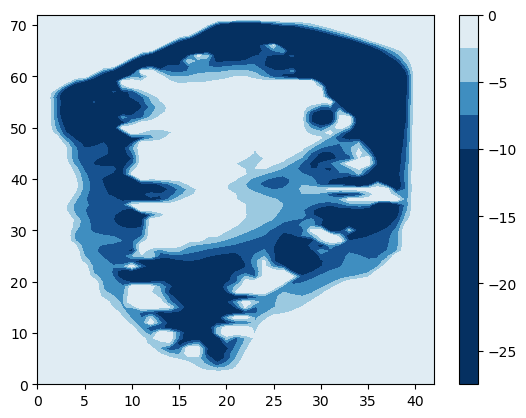

In [36]:
plt.contourf(ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init["temp_c"][0], cmap = "RdBu_r", vmin = -10, vmax = 10, levels = 10)
plt.colorbar()

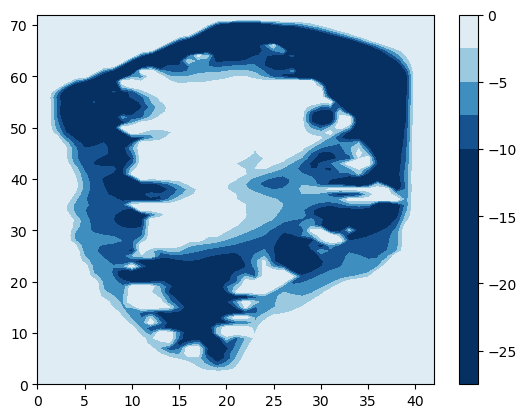

In [37]:
plt.contourf(ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init["temp_r"][-1], cmap = "RdBu_r", vmin = -10, vmax = 10, levels = 10)
plt.colorbar()

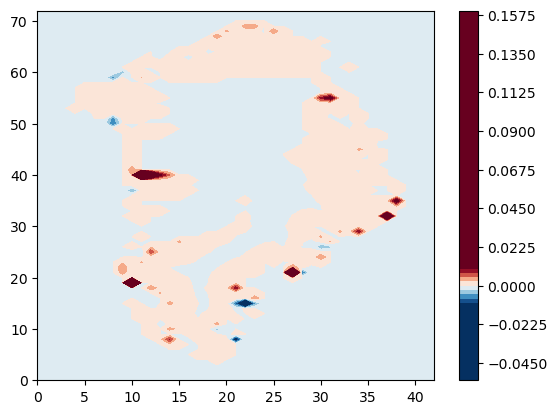

In [46]:
plt.contourf(ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init["temp_r"][-1]/ds_grl40_bm5_paleo17a_CT4_BH0_m11ka_pkp_init["temp_c"][0]-1, cmap = "RdBu_r", vmin = -0.01, vmax = 0.01, levels = 100)
plt.colorbar()

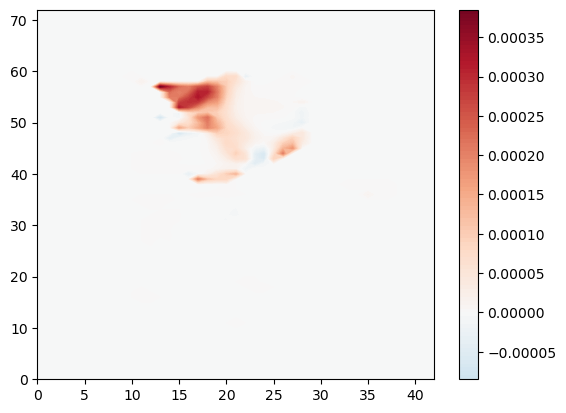

In [70]:
plt.contourf(ds_validation_genctrl_nolog["xx_temp_rb"].data[-1], cmap = "RdBu_r", vmin = -0.0004, vmax = 0.0004, levels = 100)
plt.colorbar()

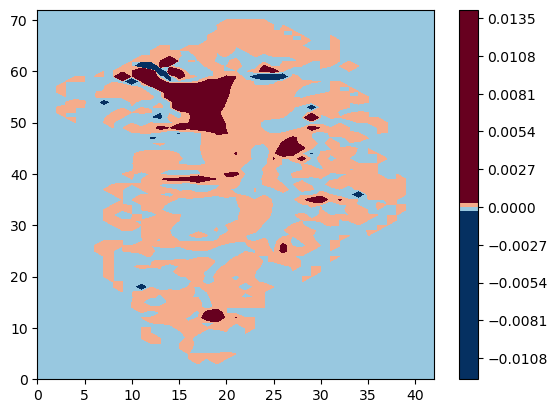

In [71]:
plt.contourf(ds_validation_genctrl_nolog["xx_temp_cb"].data[0], cmap = "RdBu_r", vmin = -0.0004, vmax = 0.0004, levels = 100)
plt.colorbar()

In [35]:
def compare(var_name, bool_log = False):
    varb_validation_genctrl_nolog = ds_validation_genctrl_nolog["xx_" + var_name + "b"].data
    if not bool_log:
        varb_validation_genctrl_prof = ds_validation_genctrl_prof["xx_" + var_name + "b"].data
    else:
        varb_validation_genctrl_prof = 10**(-dict_og_params_fields_vals["xx_" + var_name])*ds_validation_genctrl_prof["xx_" + var_name + "b"].data/np.log(10)
        
    print(np.sum(varb_validation_genctrl_nolog), 
          np.sum(varb_validation_genctrl_prof),
          np.sum(np.abs(varb_validation_genctrl_nolog)), 
          np.sum(np.abs(varb_validation_genctrl_prof)),
          np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),
          np.sum((varb_validation_genctrl_nolog == 0.0) & (varb_validation_genctrl_prof != 0.0)),
          np.sum((varb_validation_genctrl_nolog != 0.0) & (varb_validation_genctrl_prof == 0.0)))

In [36]:
compare("c_slide_init", True)

-36906.49314545212 -36904.09547530843 89442.84603419193 89445.23981142126 0.0010639377026036012 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [37]:
compare("delta_tda_const", False)

-34770.60953800539 -34774.50889801636 59127.82599048865 59127.554093910585 0.001043768347676055 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [38]:
compare("c_dis_da", True)

-3.103756431276544 -3.1038847371979985 3.6688347511782493 3.668703318527175 0.00017364039931422326 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [39]:
compare("q_geo", True)

-14653.66633783024 -14653.81033240738 51583.394428630854 51583.28921252617 3.634443493227835e-05 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [40]:
compare("gamma_s", True)

11863.20222088675 11860.43280813557 253052.45877444284 253051.74364307593 0.0010387667808535728 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [41]:
compare("s_stat", True)

-24849.29308419575 -24852.37052992064 33997.92789311879 33997.140017487014 0.0010772586524669947 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [42]:
compare("beta1", True)

-7875.697814615456 -7876.343385900058 11165.869403320845 11165.581944195957 0.0005070759370144895 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [43]:
compare("beta2", True)

-12394.28640129987 -12395.970168601714 15622.346857000844 15622.299222211524 0.0010172412359112926 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [44]:
compare("Pmax", True)

65288.01044980501 65294.519560867106 86137.64258829784 86140.08919975585 0.00119078410668072 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [45]:
compare("mu", True)

35.77922839448175 35.789310481386714 148.83698116865287 148.81665382963638 0.00012754872147624496 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [46]:
compare("RHO_A", True)

8.209646012717723 8.20996009873599 27.60136248736306 27.60247843923184 0.0014760600686296588 0 0


In [47]:
compare("time_lag_asth", True)

-1.6943351617325533 -1.6944000580877796 3.2273019234129774 3.2273244547691915 0.0006881792834700917 0 0


In [48]:
compare("flex_rig_lith", True)

2.70918318419685e-21 2.7092868325828777e-21 9.10844962082981e-21 9.10881788494651e-21 0.0014760600686301029 0 0


In [49]:
compare("p_weert", True)

5568.151445948595 5569.076833599429 17103.209757415232 17103.67468016424 0.0009387662551916254 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [50]:
compare("q_weert", True)

-10780.833828493596 -10782.80385953636 42698.81956503917 42700.11574840954 0.0013096512985308895 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [51]:
compare("enh_fact_da_dummy2d_scalar", True)

3783.156445989561 3782.4083961744277 3783.156445989561 3782.4083961744277 -0.00019773166291536803 0 0


In [52]:
compare("enh_intg_da_dummy2d_scalar", True)

-17405.88951467569 -17405.812483699847 17405.88951467569 17405.812483699847 -4.425569619659342e-06 0 0


In [53]:
compare("n_glen_da_dummy2d_scalar", True)

-9147.151006173646 -9147.140898970338 9147.151006173646 9147.140898970338 -1.1049564290210867e-06 0 0


In [54]:
compare("zs", False)

32.75031482279271 32.74776083919053 54.98662076820323 54.98846165127814 7.93219160799552e-06 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [55]:
compare("zl", False)

16.266817493793116 16.66141794813908 172.2431801910453 171.91563042205408 0.060812062080574325 0 0


In [56]:
compare("zl0", False)

168.75200091628355 168.7599836450807 596.2747897535075 596.2918073616217 0.0012555767272768303 0 0


In [57]:
compare("zb", False)

-10.500971534352582 -10.875943769700765 14.64427040326942 15.689839237988762 1.86742351471203e-06 86 100


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: divide by zero encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),
/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),
/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in multiply
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [58]:
compare("temp_c", False)

-3183.1670501515937 -3183.8762540553507 5856.132690747058 5857.0229755804185 0.00254198409133366 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [59]:
compare("omega_c", False)

-538836.4406157025 -0.00012409932927481975 993110.2923554329 0.00022870681028734808 -0.0 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [60]:
compare("age_c", True)

6.656530397531861 6.656533429021276 9.557680410937694 9.557682592115313 8.070063691079099e-06 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


In [61]:
compare("delta_tda", False)

-1.8189894035458565e-12 0.0 62392.37241802309 62393.78729011 0.006068916336801733 0 0


/tmp/ipykernel_1201010/2250920545.py:12: RuntimeWarning: invalid value encountered in divide
  np.nanmax((np.abs(varb_validation_genctrl_prof/varb_validation_genctrl_nolog) - 1.0) * (np.abs(varb_validation_genctrl_nolog) > 0.1*np.max(np.abs(varb_validation_genctrl_nolog)))),


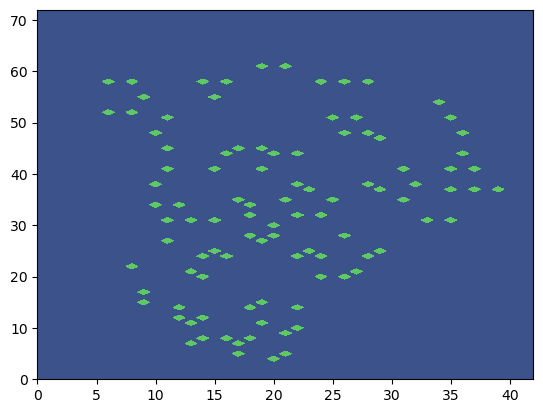

In [62]:
varb_validation_genctrl_nolog = ds_validation_genctrl_nolog["xx_zbb"].data
varb_validation_genctrl_prof = ds_validation_genctrl_prof["xx_zbb"].data

plt.contourf(((varb_validation_genctrl_nolog == 0.0) & (varb_validation_genctrl_prof != 0.0)))
plt.contourf(((varb_validation_genctrl_nolog != 0.0) & (varb_validation_genctrl_prof == 0.0)))